In [28]:
import os
import os.path as osp
import dotenv
import pandas as pd
import numpy as np
import dotenv
from snorkel import SnorkelSession

dotenv.load_dotenv('../env.sh')
%run ../src/supervision.py
session = SnorkelSession()

In [16]:
from snorkel.models import Candidate
classes = get_relation_classes()
c = session.query(classes.inducing_cytokine_class).first()
c.get_cids(), c.cytokine_cid, c.immune_cell_type_cid

(('CK2889FB46F6EE53A7:CK258F7573F98E40CA',
  'CTB7DFCED683E6F0A9:CTB7DFCED683E6F0A9'),
 'CK2889FB46F6EE53A7:CK258F7573F98E40CA',
 'CTB7DFCED683E6F0A9:CTB7DFCED683E6F0A9')

In [17]:
import re
from snorkel.lf_helpers import (
    get_tagged_text,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B,
)
#from snorkel.lf_helpers import get_text_splits
#??get_text_splits

### Text Pattern Functions

In [19]:
def ltp(x):
    x = [v for v in x if v]
    return '(' + '|'.join(x) + ')'

terms = {
    'r_diff': [
        # noun, verb (present or 3rd person present), verb (past or participle), gerund
        ('differentiation', 'differentiate', 'differentiated', 'differentiating'), 
        ('formation', 'form', 'formed', 'forming'), 
        ('generation', 'generate', 'generated', 'generating'),
        ('polarization', 'polarize', 'polarized', 'polarizing'),
        ('development', 'develop', 'developed', 'developing'),
        ('induction', None, None, None),
    ],
    'r_push': [
        ('inducer', 'induce', 'induced', 'inducing'),
        ('driver', 'drive', 'drove|driven', 'driving'),
        ('director', 'direct', 'directed', 'directing'),
        ('regulator', 'regulate', 'regulated', 'regulating'),
        ('promoter', 'promote', 'promoted', 'promoting'),
    ],
    'r_prod': [
        ('producer|production', 'produce', 'produced', 'producing'),
        ('generator|generation', 'generate', 'generated', 'generating'),
        ('creator|creation', 'create', 'created', 'creating'),
    ],
    'r_secr': [
        ('secretor|secretion', 'secrete', 'secreted', 'secreting'),
        ('expressor|expression', 'express', 'expressed', 'expressing'),
        ('producer|production', 'produce', 'produced', 'producing'),
        ('releaser|release', 'release', 'released', 'releasing'),
    ]
}
terms_map = {}
for k, v in terms.items():
    terms_map[k+'_n'] = ltp([r[0] for r in v])
    terms_map[k+'_v'] = ltp([r[1] for r in v] +[r[1]+('es' if r[1].endswith('s') else 's') for r in v if r[1]])
    terms_map[k+'_p'] = ltp([r[2] for r in v])
    terms_map[k+'_g'] = ltp([r[3] for r in v])
    
terms_map['n_do'] = '(cannot|can\'t|will not|won\'t|does not|doesn\'t|do not|don\'t)'
terms_map['wc_sm'] = '.{0,30}'
terms_map['wc_md'] = '.{0,50}'
terms_map['wc_lg'] = '.{0,150}'
terms_map['wc_xl'] = '.{0,250}'
terms_map

{'r_diff_n': '(differentiation|formation|generation|polarization|development|induction)',
 'r_diff_v': '(differentiate|form|generate|polarize|develop|differentiates|forms|generates|polarizes|develops)',
 'r_diff_p': '(differentiated|formed|generated|polarized|developed)',
 'r_diff_g': '(differentiating|forming|generating|polarizing|developing)',
 'r_push_n': '(inducer|driver|director|regulator|promoter)',
 'r_push_v': '(induce|drive|direct|regulate|promote|induces|drives|directs|regulates|promotes)',
 'r_push_p': '(induced|drove|driven|directed|regulated|promoted)',
 'r_push_g': '(inducing|driving|directing|regulating|promoting)',
 'r_prod_n': '(producer|production|generator|generation|creator|creation)',
 'r_prod_v': '(produce|generate|create|produces|generates|creates)',
 'r_prod_p': '(produced|generated|created)',
 'r_prod_g': '(producing|generating|creating)',
 'r_secr_n': '(secretor|secretion|expressor|expression|producer|production|releaser|release)',
 'r_secr_v': '(secrete|expre

In [20]:
# Induction - Positive

def subst_pattern(pattern, terms=None):
    for k, v in {**terms_map, **(terms or {})}.items():
        pattern = pattern.replace('{{' + k + '}}', v)
    return pattern

def regex_pattern(pattern, terms=None):
    return regex_search(None, pattern, terms=terms, pattern_only=True)
    
def regex_search(c, pattern, terms=None, pattern_only=False):
    # Add possible "cell" token after each cell type reference
    pattern = pattern.replace('{{B}}', '{{B}}( cell| type cell|-type cell)?')
    
    # Apply generic replacements in pattern
    pattern = subst_pattern(pattern, terms=terms)
    
    if pattern_only:
        return pattern
    return rule_regex_search_tagged_text(c, pattern, 1)

def LF_ind_pos_1(c):
    # predominance of [cytokine] drives [cell type] differentiation
    # [cytokine] regulates [cell type] differentiation
    return regex_search(c, r'{{A}}{{wc_md}}{{r_push_v}}{{wc_md}}{{B}}{{wc_md}}{{r_diff_n}}')

def LF_ind_pos_2(c):
    # Furthermore, a key inducer of both [cell type] and [cell type] cell differentiation, [cytokine] ...
    return regex_search(c, r'{{r_push_n}} of {{wc_md}}{{B}}{{wc_md}}{{r_diff_n}}{{wc_md}}{{A}}')

def LF_ind_pos_3(c):
    # [cytokine] has been shown to induce [cell type] cell differentiation
    # [cytokine] and [cytokine] induce [cell type] cell differentiation
    return regex_search(c, r'{{A}}{{wc_md}} {{r_push_v}} {{B}} {{r_diff_n}}')

def LF_ind_pos_4(c):
    # whereas [cytokine], critical for [cell type] and [cell type] cell induction
    # revealed that [cytokine] was an essential cytokine in mediating [cell type] cell development
    return regex_search(c, r'{{A}}{{wc_md}} (critical|essential|important) {{wc_md}}{{B}} {{r_diff_n}}')

def LF_ind_pos_5(c):
    # The role of [cytokine] ... to its ability to polarize T-helper cells toward the [cell type] type
    return regex_search(c, r'{{A}}{{wc_lg}}ability to {{r_diff_v}}{{wc_md}}toward{{wc_md}}{{B}}')

def LF_ind_pos_6(c):
    # [cell type] … driven by [cytokine]
    return regex_search(c, r'{{B}}{{wc_lg}} {{r_push_p}} (by|via|using|through) {{A}}')

def LF_ind_pos_7(c):
    # [cytokine] regulates [cell type] differentiation
    return regex_search(c, r'{{A}}{{wc_md}} (regulate[s]?|control[s]?) {{wc_md}}{{B}} {{r_diff_n}}')

def LF_ind_pos_8(c):
    # lacking other molecules involved in [cell type] differentiation, such as [cytokine]
    return regex_search(c, r'{{B}} {{r_diff_n}}[,]?{{wc_md}}(such as|like|including){{wc_md}}{{A}}')

def LF_ind_pos_9(c):
    # [cytokine], a component of the [cell type] paradigm
    return regex_search(c, r'{{A}}[,]?{{wc_md}}(component|part|constituent) of the {{B}}')

def LF_ind_pos_10(c):
    # confirms that [cytokine] is a critical cytokine in the commitment to [cell type] 
    return regex_search(c, r'{{A}}{{wc_lg}}(critical|essential){{wc_lg}}commitment to {{B}}')

def LF_ind_pos_11(c):
    # cells exposed to [cytokine] can … develop into [cell type]
    return regex_search(c, r'{{A}}{{wc_lg}}{{r_diff_v}} into {{B}}')

def LF_ind_pos_12(c):
    # [cell type] cells require [cytokine] for their generation
    return regex_search(c, r'{{B}}{{wc_lg}} (need[s]?|require[s]?) {{wc_lg}}{{A}}{{wc_lg}}{{r_prod_n}}')

def LF_ind_pos_13(c):
    # [cytokine] is important for differentiation of [cell type]
    return regex_search(c, r'{{A}}{{wc_lg}}(critical|essential|important){{wc_md}}{{r_diff_n}}{{wc_md}}{{B}}')
    
def LF_ind_pos_14(c):
    # [cytokine] induce(s) the development of [cell type]
    # [cytokine] promote(s) differentiation into [cell type]
    return regex_search(c, r'{{A}} {{r_push_v}}{{wc_sm}}{{r_diff_n}} (of|into) {{B}}')

def LF_ind_pos_15(c):
    # the receptors for [cytokine] are required for [cell type] differentiation
    return regex_search(c, r'receptors for{{wc_md}}{{A}}{{wc_md}}(needed|required|necessary for){{wc_md}}{{B}}{{wc_md}}{{r_diff_n}}')

def LF_ind_pos_16(c):
    # impaired human [cell type] differentiation when [cytokine] was blocked
    return regex_search(c, r'{{B}}{{wc_md}}{{r_diff_n}}{{wc_md}}when {{B}}{{wc_md}}blocked')

def LF_ind_pos_17(c):
    # [other cytokine] expression is required for [other cell type] differentiation, [cytokine] for [cell type] differentiation
    return regex_search(c, r'{{A}} for {{B}}{{wc_md}}{{r_diff_n}}')

def LF_ind_pos_18(c):
    # in [cell type] differentiation, a process driven by [cytokine]
    return regex_search(c, r'{{B}}{{wc_md}}{{r_diff_n}}{{wc_md}}{{r_push_p}} by {{A}}')

def LF_ind_pos_19(c):
    # role of [cytokine] in [cell type] differentiation
    return regex_search(c, r'role of {{A}}{{wc_md}}{{B}}{{wc_md}}{{r_diff_n}}')

def LF_ind_pos_20(c):
    # role of [cytokine] in [cell type] differentiation
    # effects of [cytokine] in [cell type] differentiation
    return regex_search(c, r'(effects|role) of {{A}}{{wc_md}}{{B}}{{wc_md}}{{r_diff_n}}')

def LF_ind_pos_21(c):
    # [cytokine] … initiate [cell type] differentiation
    return regex_search(c, r'{{A}}{{wc_md}}(initiate|trigger|induce){{wc_md}}{{B}}{{wc_md}}{{r_diff_n}}')

def LF_ind_pos_22(c):
    # [cytokine] is the most potent factor that causes [other ct] to differentiate to the [cell type] phenotype
    return regex_search(c, r'{{A}}{{wc_md}}(cause|lead|force){{wc_md}}{{r_diff_v}}{{wc_md}} (in)?to( the)? {{B}}')

def LF_ind_pos_23(c):
    # we show that [cytokine], probably secreted by APC cells, is able to polarize naive CD4+ T cells to [cell type] cells
    return regex_search(c, r'{{A}}{{wc_md}}{{r_secr_p}}cells{{wc_md}}{{r_diff_v}}{{wc_md}}{{B}}')

def LF_ind_pos_24(c):
    # It is clear that the cytokine [cytokine] directs differentiation to a [cell type] phenotype 
    # while IL-4 can drive differentiation to a Th2 phenotype
    return regex_search(c, r'{{A}}{{wc_md}}{{r_push_v}}{{wc_md}}{{r_diff_n}}{{wc_md}}{{B}}')

def LF_ind_pos_25(c):
    # upregulating IL-4 production and inhibiting IFN-γ production, thereby polarizing the differentiation of Th2 cells.
    return regex_search(c, r'{{A}} production{{wc_md}}thereby polarizing{{wc_md}}{{r_diff_n}}{{wc_md}}{{B}}')

def LF_ind_pos_26(c):
    # we show that IL-6 is able to initiate the polarization of naive CD4+ T cells to effector Th2
    return regex_search(c, r'{{A}}{{wc_sm}}{{initiate}}{{wc_sm}}{{r_diff_n}}{{wc_md}}{{B}}', {
        'initiate': '(initiate|start|cause|begin|commence|catalyze)'
    })

def LF_ind_pos_27(c):
    # the [cytokine]– mediated differentiation of [cell type] cells
    return regex_search(c, r'{{A}}.{0,10}mediated {{r_diff_n}}{{wc_md}}{{B}}')

def LF_ind_pos_28(c):
    # [cytokine] Directs the Differentiation of [cell type] Cells.
    return regex_search(c, r'{{A}}{{wc_sm}}{{r_push_v}}{{wc_sm}}{{r_diff_n}}{{wc_sm}}{{B}}')



In [21]:
# Induction - Negative

def LF_ind_neg_1(c):
    # [cytokine] cannot produce [cell type] cells de novo from naïve T cells 
    return -1*regex_search(c, r'{{wc_md}}{{A}}{{wc_md}}{{n_do}} {{r_prod_v}}{{wc_md}}{{B}}')

def LF_ind_neg_2(c):
    # [cell type] cells do not respond to [cytokine]
    return -1*regex_search(c, r'{{B}}{{wc_md}} {{n_do}} (respond|react) to {{wc_md}}{{A}}')

def LF_ind_neg_3(c):
    # Vote negative when some kind of contrasting or punctuating clause exists between references
    # expressed high levels of [cytokine]; compared to adult subsets, [cell type]
    # [cytokine] is instrumental in directing [cell type] differentiation, whereas [cytokine] promotes [cell type] differentiation
    return -1*regex_search(c, r'{{A}}{{wc_lg}} (;|:|whereas|however|although) {{wc_lg}}{{B}}')

def LF_ind_neg_4(c):
    # cells cultured in [cytokine] or low-dose IL-2 never developed into full-fledged [cell type] cells
    return -1*regex_search(c, r'{{A}}{{wc_md}}({{n_do}}|(never)){{wc_md}}{{r_diff_v}}{{wc_md}}{{B}}')

def LF_ind_neg_5(c):
    # *References to endogenous cytokines rarely make sense in the context of polarization
    # of endogenous [cytokine]
    return -1*regex_search(c, r'(endogenous|intracellular|intra-cellular){{wc_sm}}{{A}}')

def LF_ind_neg_6(c):
    # [cytokine] also antagonizes the [other cytokine]– mediated differentiation of [cell type] cells
    return -1*regex_search(c, r'{{A}}{{wc_lg}}(antagonizes|inhibits){{wc_lg}}{{B}}')
    
def LF_ind_bth_1(c):
    # Return signed result for whether or not mention of cytokine is at most X chars before cell type mention
    return 1 if re.search(r'{{A}}.{0,150}{{B}}', get_tagged_text(c), flags=re.I) else -1

In [22]:
# Secretion 

def LF_sec_pos_1(c):
    # ... regulates [cell type] differentiation, inducing [cytokine] expression
    return regex_search(c, r'{{B}}{{wc_md}}{{r_diff_n}}{{wc_md}}{{r_push_g}}{{wc_sm}}{{A}}{{wc_sm}}{{r_secr_n}}')

def LF_sec_pos_2(c):
    # [cell type] cells produce [cytokines]
    # [cell type] cells, which secrete [cytokine]
    return regex_search(c, r'{{B}}{{wc_md}}{{r_secr_v}}{{wc_sm}}{{A}}')

def LF_sec_pos_3(c):
    # induced [cell type] cell expansion and [cytokine] release
    return regex_search(c, r'{{B}}{{wc_md}}{{A}}{{wc_sm}}{{r_secr_n}}')

def LF_sec_pos_4(c):
    # Considerable amounts of [cytokine] were released by the [cell type] cells
    # significantly higher levels of [cytokine] were secreted by [cell type]
    return regex_search(c, r'{{A}}{{wc_md}}{{r_secr_p}}{{wc_md}}{{B}}')

def LF_sec_pos_5(c):
    # [cell type] cells secreted significantly higher levels of [cytokine]
    return regex_search(c, r'{{B}}{{wc_md}}{{r_secr_p}}{{wc_md}}{{A}}')

def LF_sec_pos_6(c):
    # by inducing the initial production of [cytokine] in [cell type] cells
    return regex_search(c, r'{{r_secr_n}} of {{A}}{{wc_sm}}{{B}}')

def LF_sec_pos_7(c):
    # while [cell type] are the main source of [cytokine]
    return regex_search(c, r'{{B}}{{wc_sm}}{{primary}}{{wc_sm}}{{provider}}{{wc_sm}}{{A}}', {
        'primary': '(main|primary|typical|conventional|usual|consistent)',
        'provider': '(source|provider|producer|generator|creator|supplier)'
    })


def LF_sec_bth_1(c):
    # Return signed result for whether or not mention of cell type is at most X chars before cytokine mention
    return 1 if re.search(r'{{B}}.{0,150}{{A}}', get_tagged_text(c), flags=re.I) else -1

In [23]:
# text = 'deficient in IL12A ({{A}}), a component of the {{B}} paradigm'
# pattern = regex_pattern(r'{{A}}[,]?{{wc_md}}(component|part|constituent) of the {{B}}')
# print(pattern)
# m = re.search(pattern, text, flags=re.I)
# m is not None, m

In [13]:
# Show frequency of cytokine tagged in dev set
#pd.Series([c.cytokine.get_span() for c in dev_cands]).value_counts().sort_values()

In [24]:
# from snorkel.viewer import SentenceNgramViewer
# labeled = []
# for c in session.query(InducingCytokine).filter(InducingCytokine.split == 1).all():
#     if LF_ind_pos_2(c) != 0:
#         labeled.append(c)
# print("Number labeled:", len(labeled))
# SentenceNgramViewer(labeled, session)

### Distant Supervision Functions

In [30]:
osp.join(os.environ['SUPERVISION_DATA_DIR'], 'immunexpresso', 'data.csv')

'/Users/eczech/repos/hammer/t-cell-relation-extraction/pm_subtype_protein_relations/data/supervision/immunexpresso/data.csv'

In [51]:
df_ix = pd.read_csv(osp.join(os.environ['SUPERVISION_DATA_DIR'], 'immunexpresso', 'data.csv'))
df_ix = df_ix[df_ix['cell_ref_id'].notnull() & df_ix['cytokine_ref_id'].notnull()]
print(df_ix.info())
df_ix = df_ix.set_index(['cell_ref_id', 'cytokine_ref_id']).sort_index()

def is_known_ix_ck_relation(c, actor, category):
    # Actor = 'cytokine' implies induction relationship where category in ['Positive', 'Negative', 'Unknown']
    # Actor = 'cell' implies secreation relationship and category is always 'Positive'
    ck_id, ct_id = c.cytokine_cid, c.immune_cell_type_cid
    if (ck_id, ct_id) in df_ix.index:
        df = df_ix.loc[(ck_id, ct_id)]
        df = df[(df['actor'] == actor) & (df['category'] == category)]
        if len(df) > 0:
            return True
    return False

def LF_ind_pos_imexpresso(c):
    if type(c).__name__ != classes.inducing_cytokine_class.__name__:
        return 0
    if is_known_ix_ck_relation(c, 'cytokine', 'Positive'):
        return 1
    if is_known_ix_ck_relation(c, 'cytokine', 'Negative'):
        return -1
    return 0

def LF_sec_pos_imexpresso(c):
    if type(c).__name__ != classes.secreted_cytokine_class.__name__:
        return 0
    if is_known_ix_ck_relation(c, 'cell', 'Positive'):
        return 1
    return 0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4664 entries, 13 to 6245
Data columns (total 10 columns):
actor              4664 non-null object
category           4664 non-null object
cell_id            4664 non-null object
cell_label         4664 non-null object
cytokine_id        4664 non-null object
cytokine_label     4664 non-null object
num_papers         4664 non-null int64
score              4664 non-null float64
cell_ref_id        4664 non-null object
cytokine_ref_id    4664 non-null object
dtypes: float64(1), int64(1), object(8)
memory usage: 400.8+ KB
None


### Composite Functions

In [52]:
def get_lfs(filter_fn=None):
    if filter_fn is None:
        filter_fn = lambda k: True
    gl = globals()
    return [v for k, v in gl.items() if callable(v) and filter_fn(k)]

funs_ind_neg_sec = get_lfs(lambda k: k.startswith('LF_sec_pos'))
print('LF_ind_neg_sec: Num functions composed = {} (names = {})'.format(
    len(funs_ind_neg_sec), [f.__name__ for f in funs_ind_neg_sec]
))

def LF_ind_neg_sec(c):
    # Create function that returns -1 for inducing cytokines anytime a positive hit is found on secretion
    # * should return -1 or 0
    return -1*max([f(c) for f in funs_ind_neg_sec])

LF_ind_neg_sec: Num functions composed = 8 (names = ['LF_sec_pos_1', 'LF_sec_pos_2', 'LF_sec_pos_3', 'LF_sec_pos_4', 'LF_sec_pos_5', 'LF_sec_pos_6', 'LF_sec_pos_7', 'LF_sec_pos_imexpresso'])


In [53]:
LFs = get_lfs(lambda k: k.startswith('LF_ind'))
LFs = sorted(LFs, key=lambda f: f.__name__)
print('Labeling functions found:\n{}'.format('\n'.join([f.__name__ for f in LFs])))

Labeling functions found:
LF_ind_bth_1
LF_ind_neg_1
LF_ind_neg_2
LF_ind_neg_3
LF_ind_neg_4
LF_ind_neg_5
LF_ind_neg_6
LF_ind_neg_sec
LF_ind_pos_1
LF_ind_pos_10
LF_ind_pos_11
LF_ind_pos_12
LF_ind_pos_13
LF_ind_pos_14
LF_ind_pos_15
LF_ind_pos_16
LF_ind_pos_17
LF_ind_pos_18
LF_ind_pos_19
LF_ind_pos_2
LF_ind_pos_20
LF_ind_pos_21
LF_ind_pos_22
LF_ind_pos_23
LF_ind_pos_24
LF_ind_pos_25
LF_ind_pos_26
LF_ind_pos_27
LF_ind_pos_28
LF_ind_pos_3
LF_ind_pos_4
LF_ind_pos_5
LF_ind_pos_6
LF_ind_pos_7
LF_ind_pos_8
LF_ind_pos_9
LF_ind_pos_imexpresso


### Apply to Candidates

In [70]:
from snorkel.models import candidate_subclass

#InducingCytokine = candidate_subclass('InducingCytokine', ['cytokine', 'cell_type'])
candidate_class = classes.inducing_cytokine_class
train_cands = session.query(candidate_class).filter(candidate_class.split == 0).all()
dev_cands = session.query(candidate_class).filter(candidate_class.split == 1).all()
len(train_cands), len(dev_cands)

(11817, 662)

In [65]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs)

#### Dev

In [40]:
# from snorkel.annotations import load_matrix
# ??load_matrix

In [56]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1, load_as_array=False)

In [57]:
L_gold_dev

<1779x1 sparse matrix of type '<class 'numpy.int64'>'
	with 257 stored elements in Compressed Sparse Row format>

In [66]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1, load_as_array=True)
# Labels return as 0 when a candidate has no gold label loaded but in this case,
# unlabeled candidates in the dev set are to be treated as negative instances
L_gold_dev = np.where(L_gold_dev == 1, 1, -1)
assert np.all(np.in1d(L_gold_dev, [-1, 1]))
L_gold_dev[:100]

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1,  1, -1,  1, -1, -1,  1,
       -1,  1,  1, -1, -1, -1, -1,  1, -1, -1, -1, -1,  1, -1, -1, -1,  1,
       -1,  1, -1, -1,  1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1])

In [67]:
np.unique(L_gold_dev, return_counts=True)

(array([-1,  1]), array([1522,  257]))

In [68]:
L_dev = labeler.apply_existing(split=1)


  0%|          | 6/1779 [00:00<00:34, 51.92it/s]

Clearing existing...
Running UDF...



 49%|████▉     | 875/1779 [00:17<00:17, 51.73it/s]


 92%|█████████▏| 1637/1779 [00:34<00:03, 45.29it/s]


100%|██████████| 1779/1779 [00:37<00:00, 46.61it/s]

In [69]:
L_dev.toarray()

array([], shape=(1779, 0), dtype=float64)

In [62]:
L_dev.lf_stats(session, L_gold_dev)

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.


In [131]:
L_dev.lf_stats(session, L_gold_dev)

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
LF_ind_bth_1,0,1.000000,0.398810,0.059524,23,40,7,98,0.720238
LF_ind_neg_1,1,0.000000,0.000000,0.000000,0,0,0,0,NaN
LF_ind_neg_2,2,0.000000,0.000000,0.000000,0,0,0,0,NaN
LF_ind_neg_3,3,0.017857,0.017857,0.017857,0,0,0,3,1.000000
LF_ind_neg_4,4,0.000000,0.000000,0.000000,0,0,0,0,NaN
LF_ind_neg_5,5,0.000000,0.000000,0.000000,0,0,0,0,NaN
LF_ind_neg_6,6,0.000000,0.000000,0.000000,0,0,0,0,NaN
LF_ind_neg_sec,7,0.154762,0.154762,0.005952,0,0,0,26,1.000000
LF_ind_pos_1,8,0.071429,0.071429,0.000000,12,0,0,0,1.000000
LF_ind_pos_10,9,0.011905,0.011905,0.000000,1,1,0,0,0.500000


In [249]:
df_dev = pd.DataFrame(L_dev.toarray()).assign(label=L_gold_dev)
df_dev.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,label
0,-1,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
2,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1


In [251]:
# lf_idx = [f.__name__ for f in LFs].index('LF_ind_pos_1')
# lf_hits = df_dev[df_dev[lf_idx] > 0]
# cands = [dev_cands[i] for i in lf_hits.index]
# print(cands)
# lf_hits

In [105]:
np.argwhere(L_gold_dev > 0).squeeze()

array([  4,   8,  32,  37,  40,  47,  49,  52,  54,  56,  58,  61,  63,
        65,  69,  73,  81,  82,  93, 106, 107, 113, 122, 132, 136, 141,
       145, 151, 154, 159])

In [106]:
cand = dev_cands[58]

In [107]:
cand

InducingCytokine(Span("b'TGF-\xce\xb2'", sentence=11470, chars=[89,93], words=[15,15]), Span("b'iTreg'", sentence=11470, chars=[118,122], words=[21,21]))

In [108]:
cand.get_parent()

Sentence(Document PMC2646571,34,b'We report that Gfi-1 suppresses both Th17 and CD103+ iTreg cell differentiation, whereas TGF-\xce\xb2, critical for Th17 and iTreg cell induction, down-regulates Gfi-1 expression.')

#### Training

In [109]:
%time L_train = labeler.apply(split=0)
L_train

  0%|          | 16/8011 [00:00<00:52, 152.03it/s]

Clearing existing...
Running UDF...


100%|██████████| 8011/8011 [00:48<00:00, 164.49it/s]


CPU times: user 47 s, sys: 774 ms, total: 47.7 s
Wall time: 48.9 s


<8011x36 sparse matrix of type '<class 'numpy.int64'>'
	with 9367 stored elements in Compressed Sparse Row format>

In [110]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_ind_bth_1,0,1.000000,0.142679,0.042317
LF_ind_neg_1,1,0.000250,0.000250,0.000250
LF_ind_neg_2,2,0.000000,0.000000,0.000000
LF_ind_neg_3,3,0.008239,0.008239,0.006117
LF_ind_neg_4,4,0.000125,0.000125,0.000125
LF_ind_neg_5,5,0.009986,0.009986,0.004993
LF_ind_neg_6,6,0.006241,0.006241,0.005742
LF_ind_neg_sec,7,0.082886,0.082886,0.023468
LF_ind_pos_1,8,0.013232,0.013232,0.000874
LF_ind_pos_10,9,0.000000,0.000000,0.000000


## Train Generative Model

In [111]:
from snorkel.learning.structure import DependencySelector
ds = DependencySelector()
deps = ds.select(L_train, threshold=0.1)
len(deps)

6

In [112]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel(lf_propensity=True)
gen_model.train(
    L_train, deps=deps, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=0.0
)

Inferred cardinality: 2


In [113]:
train_marginals = gen_model.marginals(L_train)

In [114]:
train_marginals.shape

(8011,)

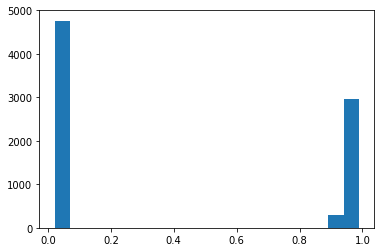

In [115]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [116]:
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.955184,0.8546,0.954741,0.813693
1,0.579286,0.4509,0.597706,0.261331
2,0.586646,0.4628,0.601465,0.269238
3,0.592625,0.4529,0.616957,0.273674
4,0.590461,0.4466,0.602004,0.254966
5,0.592068,0.4589,0.613750,0.284089
6,0.588872,0.4619,0.609745,0.267888
7,0.612287,0.4867,0.631961,0.302025
8,0.619335,0.2648,0.636971,0.165477
9,0.580435,0.4457,0.591412,0.257666


In [117]:
from snorkel.annotations import save_marginals
save_marginals(session, L_train, train_marginals)

Saved 8011 marginals


In [118]:
_ = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.767
Neg. class accuracy: 0.71
Precision            0.365
Recall               0.767
F1                   0.495
----------------------------------------
TP: 23 | FP: 40 | TN: 98 | FN: 7



In [120]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
LF_ind_bth_1,0,1.000000,0.345238,0.041667,23,40,7,98,0.720238
LF_ind_neg_1,1,0.000000,0.000000,0.000000,0,0,0,0,NaN
LF_ind_neg_2,2,0.000000,0.000000,0.000000,0,0,0,0,NaN
LF_ind_neg_3,3,0.154762,0.154762,0.005952,0,0,0,26,1.000000
LF_ind_neg_4,4,0.071429,0.071429,0.000000,12,0,0,0,1.000000
LF_ind_neg_5,5,0.011905,0.011905,0.000000,1,1,0,0,0.500000
LF_ind_neg_6,6,0.029762,0.029762,0.000000,5,0,0,0,1.000000
LF_ind_neg_sec,7,0.011905,0.011905,0.011905,2,0,0,0,1.000000
LF_ind_pos_1,8,0.029762,0.029762,0.000000,1,4,0,0,0.200000
LF_ind_pos_10,9,0.000000,0.000000,0.000000,0,0,0,0,NaN
